# AutoregressiveModel

**Description:** AutoregressiveModel implemented in Keras to generate image.

**Objective:** The objective of this assignment is to practise using the TensorFlow machine learning framework
through implementing custom training modules and data reader modules for image generation on
the Chinese Calligraphy dataset using a convolutional neural network (CNN) based architecture.
Throughout the assignment, students will be guided to develop the CNN-based model step by
step and study how to build custom modules on TensorFlow and the effects of different model
configurations.

## Introduction

Image generation is one of the fundamental computer vision tasks, referring to the process of generating new images that are visually realistic and similar to real-world images. It is widely used in many applications, such as super resolution, photograph editing and 3D modelling. 

One approach to image generation is to use models that learn to predict the probability distribution of pixel values, given the values of all the previous pixels. These models generate images one pixel at a time, using the previously generated pixels to condition the generation of the next pixel.

### Setting environment

Note: You can only use the packages listed below !!!

In [26]:
import numpy as np
import math
import os
from PIL import Image
import time
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

print(tf.__version__)

print('1: ', tf.config.list_physical_devices('GPU'))
print('2: ', tf.test.is_built_with_cuda)
print('3: ', tf.test.gpu_device_name())
print('4: ', tf.config.get_visible_devices())


2.12.0
1:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2:  <function is_built_with_cuda at 0x7f2d832bf820>
3:  /device:GPU:0
4:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-04-03 16:39:51.238090: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-03 16:39:51.254029: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-03 16:39:51.254074: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-03 16:39:51.256106: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-03 16:39:51.256163: I tensorflow/compile

## Getting the data


### Download dataset



In [3]:
# Download dataset from google drive
# ! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=18ogOIVtYFkcCyNN6AHLCrTI95zMrYAZt' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=18ogOIVtYFkcCyNN6AHLCrTI95zMrYAZt" -O calligraphy.zip && rm -rf /tmp/cookies.txt
# ! mkdir ./data && unzip -q calligraphy.zip -d ./data/ && rm calligraphy.zip
# ! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1w7JVXz6U-NVDZxBf1oSAVjKdR4BJs1zI' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1w7JVXz6U-NVDZxBf1oSAVjKdR4BJs1zI" -O calligraphy.zip && rm -rf /tmp/cookies.txt
# ! unzip -q calligraphy.zip -d ./data/ && rm calligraphy.zip
# ! ls -l ./data

### make dataset

In [3]:
# Model / data parameters
input_shape = (32, 32, 1)
batch_size = 32
data_dir = "./train"
data_name = "calligraphy"

In [4]:
# dataset class
class CalligraphySequence(tf.keras.utils.Sequence):

    def __init__(self, image_dir, batch_size):
        ### [C1: Build init and len functions]
        # Your code here
        self.batch_size = batch_size
        self.image_dir = image_dir

        self.files = os.listdir(self.image_dir)

    def __len__(self):
        ### [C1: Build init and len functions]
        # Your code here
        return math.ceil(len(os.listdir(self.image_dir))/self.batch_size)

    def __getitem__(self, idx):
        ### [C2: Build getitem function]
        # Round all pixel values less than 33% of the max 256 value to 0
        # anything above this value gets rounded up to 1 so that all values are either
        # 0 or 1
        # Your code here
        
        low = idx * self.batch_size
        high = min(low + self.batch_size, len(self.files))
        batch = self.files[low:high]

        imgs = [Image.open(os.path.join(self.image_dir,file)) for file in batch]
        for i,img in enumerate(imgs):
            grey_pic = img.convert('L')
            resize_pic = grey_pic.resize((32,32))
            imgs[i] = np.asarray(resize_pic)

        layer = tf.keras.layers.Normalization()
        layer.adapt(np.array(imgs))
        normalized_data = layer(imgs)

        binarized = tf.where(normalized_data < 0.33, 0, 1)

        return np.array(binarized)[:,:,:,np.newaxis],np.array(binarized)[:,:,:,np.newaxis]

# final shape should be 1313 (32, 32, 32, 1) (32, 32, 32, 1)
train_ds = CalligraphySequence(data_dir, batch_size)
print(len(train_ds), train_ds[0][0].shape, train_ds[0][1].shape)

2023-04-03 16:39:57.237950: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-03 16:39:57.238043: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-03 16:39:57.238074: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-03 16:39:57.238352: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-03 16:39:57.238365: I tensorflow/core/co

1313 (32, 32, 32, 1) (32, 32, 32, 1)


In [6]:
# split into validate dataset
files = os.listdir(data_dir)

num_files_to_copy = int(len(files) * 0.2)
print(num_files_to_copy)
for i in range(num_files_to_copy):
    os.system(f'cp ./train/{files[i]} ./split_validate/{files[i]}')
files = files[::-1]
for i in range(len(files) - num_files_to_copy):
    os.system(f'cp ./train/{files[i]} ./split_train/{files[i]}')


8400


In [6]:
validate_ds = CalligraphySequence('./split_validate', batch_size)
splitted_train_ds = CalligraphySequence('./split_train', batch_size)
print(len(train_ds))
print(len(splitted_train_ds))
print(len(validate_ds))

1313
1050
263


## Create layers for the requisite Layers for the model


### Given function for conv2d / down_shift / right_shift / concat_elu
1. conv2d: 2d convolution layer using layers.Conv2D

2. down_shift: shift feature down in height dimension (by padding zero to the top and drop the bottom)

3. right_shift: shift feature right in width dimension

4. concat_elu: a nonlinearity layer (http://arxiv.org/abs/1603.05201)

The down_shift and right_shift functions are used to avoid information leaks in a causal network.


In [7]:
class Conv2d(layers.Layer):
    def __init__(self, num_filters, filter_size=[3, 3], stride=[1, 1], pad='SAME', nonlinearity=None, **kwargs):
        super().__init__()
        self.conv = layers.Conv2D(num_filters, filter_size, padding = pad, strides = stride, activation = nonlinearity, 
                         kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05))

    def call(self, x):
        return self.conv(x)

def down_move(x, step=1):
    input_shape = tf.shape(x)
    return tf.concat([tf.zeros((input_shape[0], step, input_shape[2], input_shape[3])), x[:, :input_shape[1] - step, :, :]], 1)

def right_move(x, step=1):
    input_shape = tf.shape(x)
    return tf.concat([tf.zeros((input_shape[0], input_shape[1], step, input_shape[3])), x[:, :, :input_shape[2] - step, :]], 2)

def concat_elu(x):
    """ like concatenated ReLU (http://arxiv.org/abs/1603.05201), but then with ELU """
    axis = len(x.get_shape()) - 1
    out = tf.nn.elu(tf.concat([x, -x], axis))
    return out

### Gated Residual Block
The GatedResnet class applies gated residual connections to input tensors for feature extraction.

Please follow Section 4.2.3 to implement coding question.


In [8]:
class DownMovedConv2d(layers.Layer):
    def __init__(self, num_filters, filter_size=[2, 3], stride=[1, 1], pad='VALID', nonlinearity=None, **kwargs):
        super().__init__()
        ### [C4: Build DownMovedConv2d.]
        # Your code here
        self.filter_size = filter_size

        self.conv = tf.keras.layers.Conv2D(filters=num_filters, kernel_size= self.filter_size, padding = pad, strides = stride, activation = nonlinearity, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), data_format='channels_last')
        

    def call(self, x):
        ### [C4: Build DownMovedConv2d.]
        # Your code here
        paddings = tf.constant([[0,0],[self.filter_size[0]-1,0],[(self.filter_size[1]-1)//2,(self.filter_size[1]-1)//2],[0,0]])
        padded = tf.pad(x, paddings=paddings)
        return self.conv(padded)


class DownRightMovedConv2d(layers.Layer):
    def __init__(self, num_filters, filter_size=[2, 2], stride=[1, 1], pad='VALID', nonlinearity=None, **kwargs):
        super().__init__()
        ### [C3: Build DownRightMovedConv2d.]
        # Your code here

        self.filter_size = filter_size
        self.conv = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=self.filter_size, padding = pad, strides = stride, activation = nonlinearity, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), data_format='channels_last')

    def call(self, x):
        ### [C3: Build DownRightMovedConv2d.]
        # Your code here
        paddings = tf.constant([[0,0],[self.filter_size[0]-1,0],[self.filter_size[1]-1,0],[0,0]])
        padded = tf.pad(x,paddings=paddings)
        return self.conv(padded)


class TensorDense(layers.Layer):
    def __init__(self, num_units, nonlinearity=None, **kwargs):
        super().__init__()
        ### [C5: Build TensorDense.]
        # Your code here
        self.num_units = num_units
        self.dense = tf.keras.layers.Dense(self.num_units,activation=nonlinearity, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05))

    def call(self, x):
        ### [C5: Build TensorDense.]
        # Your code here
        shape = tf.shape(x)
        densed = self.dense(tf.reshape(x, [shape[0]*shape[1]*shape[2],shape[3]]))
        return tf.reshape(densed, [shape[0], shape[1], shape[2], self.num_units])


class GatedResnet(layers.Layer):
    def __init__(self, num_filters, nonlinearity=concat_elu, **kwargs):
        super().__init__()
        ### [C6: Build GatedResnet.]
        # Your code here
        self.nnLayer_1 = DownRightMovedConv2d(num_filters)
        self.nnLayer_2 = DownRightMovedConv2d(num_filters*2)
        self.nonlinearity = nonlinearity

    def call(self, x):
        ### [C6: Build GatedResnet.]
        # Your code here

        #1.
        y = tf.keras.layers.Activation(self.nonlinearity)(x)
        y = self.nnLayer_1(y)

        y = tf.keras.layers.Activation(self.nonlinearity)(y)
        y = self.nnLayer_2(y)

        # 2.feature gated stategy
        f,g = tf.split(y, 2, 3)

        gated_output = tf.math.multiply(f, tf.math.sigmoid(g))

        #3. residual connection
        return tf.math.add(x, gated_output)

### Main AutoregressiveModel

In [9]:
class AutoregressiveModel(layers.Layer):
    def __init__(self, n_resnet=5, n_filters=256, n_block=12, n_output=10, **kwargs):
        super().__init__()
        self.n_resnet = n_resnet
        self.n_filters = n_filters
        self.n_block = n_block
        self.n_output = n_output
        # init all network layers
        self.down_moved_conv2d = DownMovedConv2d(num_filters=self.n_filters, filter_size=[1, 3])
        self.down_right_moved_conv2d = DownRightMovedConv2d(num_filters=self.n_filters, filter_size=[2, 1])

        ### [C7: Build AutoregressiveModel.]
        # Your code here
        self.out_dense = TensorDense(num_units=self.n_output)
        self.ul_list_gated_resnet = []
        self.ul_list_dense_layer = []
        for m in range(self.n_block):
            for n in range(self.n_resnet):
                self.ul_list_gated_resnet.append(GatedResnet(num_filters=n_filters))
            self.ul_list_dense_layer.append(TensorDense(num_units=n_filters))
        


    def call(self, inputs):
        input_shape = tf.shape(inputs)
        x = down_move(self.down_moved_conv2d(inputs)) + right_move(self.down_right_moved_conv2d(inputs))
        ### [C7: Build AutoregressiveModel.]
        # Your code here
        # Network Block 
        for m in range(self.n_block):
            for n in range(self.n_resnet):
                x = self.ul_list_gated_resnet[m*self.n_resnet+n](x)
            x = self.ul_list_dense_layer[m](x)
        # 5.
        x = tf.keras.layers.Activation(tf.nn.elu)(x)
        x_out = self.out_dense(x)


        return x_out


## Build the model based on the original paper


In [10]:
## Build the model based on the original paper
inputs = keras.Input(shape=input_shape, dtype=tf.float32)
x = AutoregressiveModel(n_resnet=6, n_filters=64, n_block=6, n_output=10)(inputs)
out = keras.layers.Conv2D(
    filters=1, kernel_size=1, strides=1, activation="sigmoid", padding="valid"
)(x)

pixel_cnn = keras.Model(inputs, out)
### [C11: Model training and log reporting]
# you can use keras.optimizers.Adam here to define "adam"
# compile your model and make a summary on its architecture
# Your code here


pixel_cnn.summary()
pixel_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001,
beta_1=0.95, beta_2=0.9995, epsilon=1e-6, use_ema=True, ema_momentum=0.9995),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 autoregressive_model (Autor  (None, 32, 32, 10)       3571914   
 egressiveModel)                                                 
                                                                 
 conv2d_74 (Conv2D)          (None, 32, 32, 1)         11        
                                                                 
Total params: 3,571,925
Trainable params: 3,571,925
Non-trainable params: 0
_________________________________________________________________


In [11]:
#evaluate with no weight

test_ds = CalligraphySequence('./test', batch_size)

pixel_cnn.evaluate(x=test_ds)


2023-04-03 16:40:26.662385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2023-04-03 16:40:29.368906: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


33/33 [==============================] - 10s 193ms/step - loss: 0.6918 - accuracy: 0.6191


[0.6917984485626221, 0.619050145149231]

In [12]:
### [C8: Load the pretrained weights]
# Your code here
pixel_cnn.load_weights('pixel_cnn_e5.h5')
# model = tf.keras.models.Model.load_weights(pixel_cnn,)
print(pixel_cnn.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 autoregressive_model (Autor  (None, 32, 32, 10)       3571914   
 egressiveModel)                                                 
                                                                 
 conv2d_74 (Conv2D)          (None, 32, 32, 1)         11        
                                                                 
Total params: 3,571,925
Trainable params: 3,571,925
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
#evalutate with loaded weights
history = pixel_cnn.evaluate(x=test_ds)


2023-04-03 16:40:36.793706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


33/33 [==============================] - 6s 193ms/step - loss: 0.3679 - accuracy: 0.8658


In [14]:
### [C11: Model training and log reporting]
# you can use model.fit here
# Your code here
pixel_cnn.fit(x=splitted_train_ds, epochs=10, validation_data=validate_ds)

Epoch 1/10


2023-04-03 16:40:43.463567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-03 16:40:55.859193: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f2b3bd92570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-03 16:40:55.859230: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 2080, Compute Capability 7.5
2023-04-03 16:40:55.862904: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-03 16:40:55.960226: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once 

1050/1050 [==============================] - ETA: 0s - loss: 0.2146 - accuracy: 0.9113

2023-04-03 16:46:48.135528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1050/1050 [==============================] - 415s 372ms/step - loss: 0.2146 - accuracy: 0.9113 - val_loss: 0.2061 - val_accuracy: 0.9140
Epoch 2/10
1050/1050 [==============================] - 386s 367ms/step - loss: 0.2045 - accuracy: 0.9146 - val_loss: 0.2034 - val_accuracy: 0.9152
Epoch 3/10
1050/1050 [==============================] - 368s 351ms/step - loss: 0.2021 - accuracy: 0.9157 - val_loss: 0.2017 - val_accuracy: 0.9159
Epoch 4/10
1050/1050 [==============================] - 366s 349ms/step - loss: 0.2004 - accuracy: 0.9163 - val_loss: 0.2005 - val_accuracy: 0.9163
Epoch 5/10
1050/1050 [==============================] - 364s 347ms/step - loss: 0.1991 - accuracy: 0.9169 - val_loss: 0.1998 - val_accuracy: 0.9165
Epoch 6/10
1050/1050 [==============================] - 386s 368ms/step - loss: 0.1981 - accuracy: 0.9173 - val_loss: 0.2000 - val_accuracy: 0.9166
Epoch 7/10
1050/1050 [==============================] - 388s 369ms/step - loss: 0.1974 - accuracy: 0.9177 - val_loss: 0.199

In [15]:
# save weights 
pixel_cnn.save_weights('pixel_cnn_e15.h5')

## Demonstration

The AutoregressiveModel cannot generate the full image at once. Instead, it must generate each pixel in
order, append the last generated pixel to the current image, and feed the image back into the
model to repeat the process.

In [ ]:
from IPython.display import Image, display

# Create an empty array of pixels.
batch = 10 # you may want to change this parameter 
pixels = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols, channels = pixels.shape
print(pixels.shape)

# Iterate over the pixels because generation has to be done sequentially pixel by pixel.
for pic in range(batch):
    for row in tqdm(range(rows)):
        for col in range(cols):
            for channel in range(channels):
                ### [C9: Qualitative Evaluation]
                # Your code here
                # 1. Feed the whole array and retrieving the pixel value probabilities for the next
                # pixel. You can use model.predict function to get predict value for each pixel.
                result = pixel_cnn.predict(pixels, verbose=0)
                # 2. Use the probabilities to pick pixel values and append the values to the image
                # frame. you can use tf.math.ceil to achieve the 0.5 threshold.
                random = tf.random.uniform([],maxval=1)
                # print(random)
                # print(result[0][row][col][channel])
                pixels[pic][row][col][channel] = tf.math.ceil(result[pic][row][col][channel] + tf.random.uniform([],maxval=1) - 1)
                # print(pixels[0][row][col][channel])


def deprocess_image(x):
    # Stack the single channeled black and white image to RGB values.
    x = np.stack((x, x, x), 2)
    # Undo preprocessing
    x *= 255.0
    # Convert to uint8 and clip to the valid range [0, 255]
    x = np.clip(x, 0, 255).astype("uint8")
    return x


# Iterate over the generated images and plot them with matplotlib.
for i, pic in enumerate(pixels):
    keras.preprocessing.image.save_img(
        "generated_image_{}.png".format(i), deprocess_image(np.squeeze(pic, -1))
    )

# display(Image("generated_image_0.png"))
# display(Image("generated_image_1.png"))
# display(Image("generated_image_2.png"))
# display(Image("generated_image_3.png"))

(10, 32, 32, 1)


100%|██████████| 32/32 [01:33<00:00,  2.91s/it]


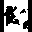

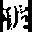

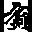

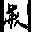

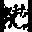

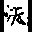

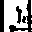

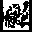

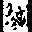

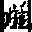

In [21]:
for i in range(10):
    display(Image(f'generated_image_{i}.png'))

## Quantitative Evaluation



In [23]:
pixel_cnn

In [28]:
### [C10: Quantitative Evaluation]
# Your code here

# test_ds = CalligraphySequence('./test', batch_size)
pixel_cnn.evaluate(x = test_ds)

2023-04-03 18:14:36.016182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


33/33 [==============================] - 7s 198ms/step - loss: 0.1953 - accuracy: 0.9187


[0.19528882205486298, 0.9186841249465942]